In [1]:
import pandas as pd
import numpy as np

# Simulation

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

n_rows = 10000
n_cols = 20

print(f"{int(n_cols/4)} key features")

5 key features


In [3]:
from generate_simulation_data import generate_simulation_data
df = generate_simulation_data(num_rows=n_rows, num_numeric_columns=n_cols)

In [4]:
df['Y'].value_counts()

0    9000
1    1000
Name: Y, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Splitting data into features (X) and target (Y)
X = df.drop(columns=['Y'])
Y = df['Y']

# Splitting data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Accuracy: 0.746
Logistic Regression AUC Score: 0.7803809173218339


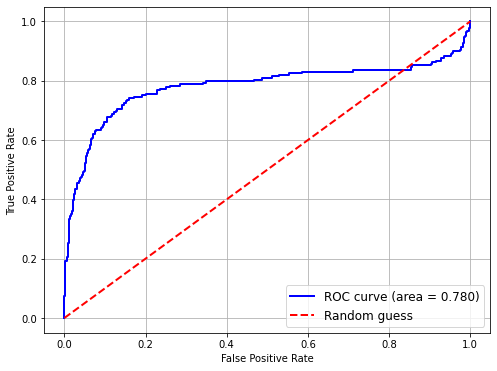

F1 Score: 0.36658354114713215
Top 5 features selected: ['X1', 'X2', 'X5', 'X13', 'X10']


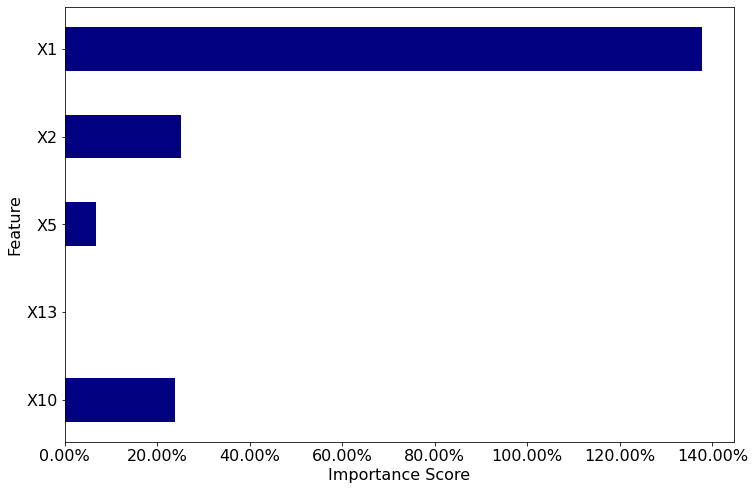

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

name = "Logistic Regression"

# Fitting Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

# Predict probabilities on the test set
Y_pred = log_reg.predict_proba(X_test)[:, 1]
Y_pred_binary = (Y_pred > 0.1).astype(int)  # Converting predicted probabilities to binary
Y_pred_1 = Y_pred

accuracy = accuracy_score(Y_test, Y_pred_binary)
print("Accuracy:", accuracy)

# Calculate AUC score
auc_score_log_reg = roc_auc_score(Y_test, Y_pred)
print("Logistic Regression AUC Score:", auc_score_log_reg)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title(f'ROC Curve of {name}')
plt.legend(loc='lower right', fontsize='large')
plt.grid(True)
plt.savefig(f'roc_curve_{name.lower().replace(" ", "_")}.png', bbox_inches='tight', dpi=500)
plt.show()

# Calculate F1 score
f1 = f1_score(Y_pred_binary, Y_test)
print("F1 Score:", f1)

# Get coefficients (feature importances)
feature_importances = log_reg.coef_.tolist()[0]

# Rank features based on their coefficients
ranked_features = sorted(range(len(feature_importances)), key=lambda i: abs(feature_importances[i]), reverse=True)
print(f"Top {int(n_cols/4)} features selected: {[X_train.columns[i] for i in ranked_features][:int(n_cols/4)]}")

import matplotlib.ticker as ticker
# Set custom font size
plt.rcParams.update({'font.size': 16})

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar chart
ax.barh([X_train.columns[i] for i in ranked_features][:int(n_cols/4)], [abs(i) for i in feature_importances][:int(n_cols/4)], color='navy', height=0.5)

# Set axis labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')


# Invert y-axis for better readability
ax.invert_yaxis()

# Save the plot as a PNG file
#plt.savefig('feature_importance_simulated.png', bbox_inches='tight', dpi=500)

# Show plot
plt.show()

Accuracy: 0.56
AUC Score: 0.7830395671367512


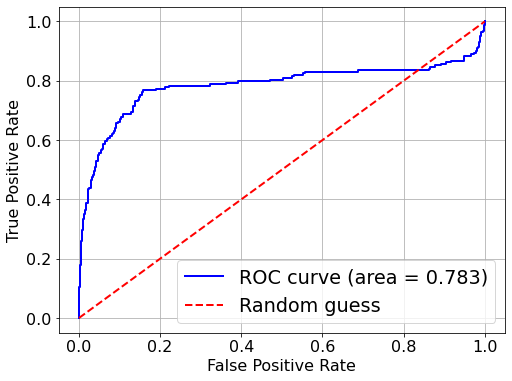

F1 Score: 0.2554991539763113
Selected 24 Features:
Index(['X1', 'X2', 'X3', 'X5', 'X10', 'X17', 'X20', 'X11_correlated_2',
       'X12_correlated_2', 'X12_correlated_4', 'X18_correlated_4',
       'X19_correlated_1', 'X19_correlated_3', 'X19_correlated_4',
       'X3_correlated_1', 'X3_correlated_2', 'X15_correlated_2',
       'X8_correlated_1', 'X8_correlated_3', 'X8_correlated_4',
       'X13_correlated_1', 'X13_correlated_2', 'X13_correlated_4',
       'X14_correlated_1'],
      dtype='object')
4 features successfully captured
Top 5 features selected: ['X1', 'X5', 'X2', 'X10', 'X3_correlated_1']


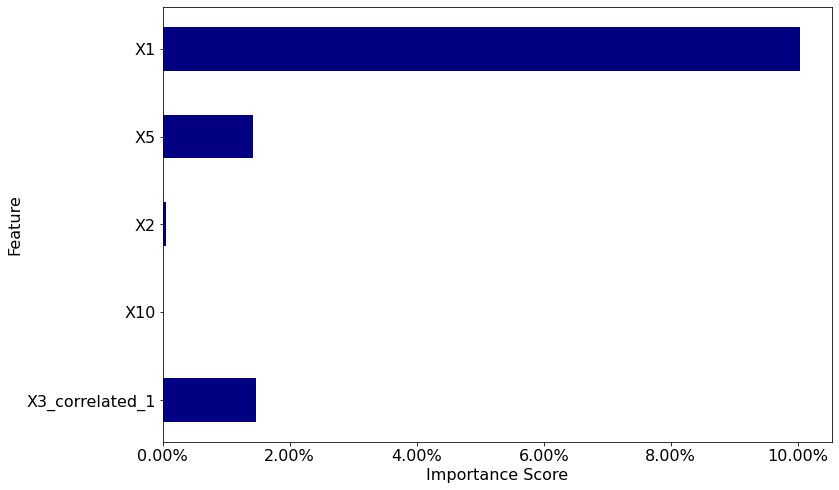

In [7]:
from sklearn.linear_model import ElasticNetCV

name = "Elastic Net"

# Fit Elastic Net model with cross-validation to select features
enet = ElasticNetCV(cv=10, random_state=42, l1_ratio=0.99)
enet.fit(X_train, Y_train)

# Predict on the test set
Y_pred = enet.predict(X_test)
Y_pred_binary = (Y_pred > 0.1).astype(int)  # Converting predicted probabilities to binary
Y_pred_2 = Y_pred

accuracy = accuracy_score(Y_test, Y_pred_binary)
print("Accuracy:", accuracy)

# Calculate AUC score
auc_score = roc_auc_score(Y_test, Y_pred)
print("AUC Score:", auc_score)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', fontsize='large')
plt.grid(True)
plt.savefig(f'roc_curve_{name.lower().replace(" ", "_")}.png', bbox_inches='tight', dpi=500)
plt.show()

# Calculate F1 score
f1 = f1_score(Y_pred_binary, Y_test)
print("F1 Score:", f1)

# Get selected features
selected_features = X.columns[enet.coef_ != 0]
print(f"Selected {len(selected_features)} Features:")
print(selected_features)
select_features_simplified = list(set([f.split("_")[0] for f in list(selected_features)]))
successful_selections = [f for f in select_features_simplified if int(f.split("X")[-1]) <= int(n_cols/4)]
print(f"{len(successful_selections)} features successfully captured")

# Get coefficients (feature importances)
feature_importances = enet.coef_

# Rank features based on their coefficients
ranked_features = sorted(range(len(feature_importances)), key=lambda i: abs(feature_importances[i]), reverse=True)
print(f"Top {int(n_cols/4)} features selected: {[X_train.columns[i] for i in ranked_features][:int(n_cols/4)]}")

import matplotlib.ticker as ticker
# Set custom font size
plt.rcParams.update({'font.size': 16})

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar chart
ax.barh([X_train.columns[i] for i in ranked_features][:int(n_cols/4)], [abs(i) for i in feature_importances][:int(n_cols/4)], color='navy', height=0.5)

# Set axis labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')


# Invert y-axis for better readability
ax.invert_yaxis()

# Save the plot as a PNG file
#plt.savefig('feature_importance_simulated.png', bbox_inches='tight', dpi=500)

# Show plot
plt.show()

Random Forest Accuracy: 0.9225
Random Forest AUC Score: 0.8151040525419322


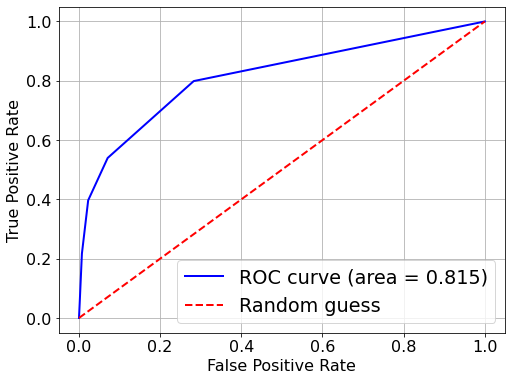

F1 Score: 0.4918032786885246
Selected Features: Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X11_correlated_1', 'X11_correlated_2', 'X11_correlated_3',
       'X11_correlated_4', 'X12_correlated_1', 'X12_correlated_2',
       'X12_correlated_3', 'X12_correlated_4', 'X18_correlated_1',
       'X18_correlated_2', 'X18_correlated_3', 'X18_correlated_4',
       'X19_correlated_1', 'X19_correlated_2', 'X19_correlated_3',
       'X19_correlated_4', 'X6_correlated_1', 'X6_correlated_2',
       'X6_correlated_3', 'X6_correlated_4', 'X3_correlated_1',
       'X3_correlated_2', 'X3_correlated_3', 'X3_correlated_4',
       'X15_correlated_1', 'X15_correlated_2', 'X15_correlated_3',
       'X15_correlated_4', 'X8_correlated_1', 'X8_correlated_2',
       'X8_correlated_3', 'X8_correlated_4', 'X13_correlated_1',
       'X13_correlated_2', 'X13_correlated_3', 'X13_correlated_4',
       'X14_cor

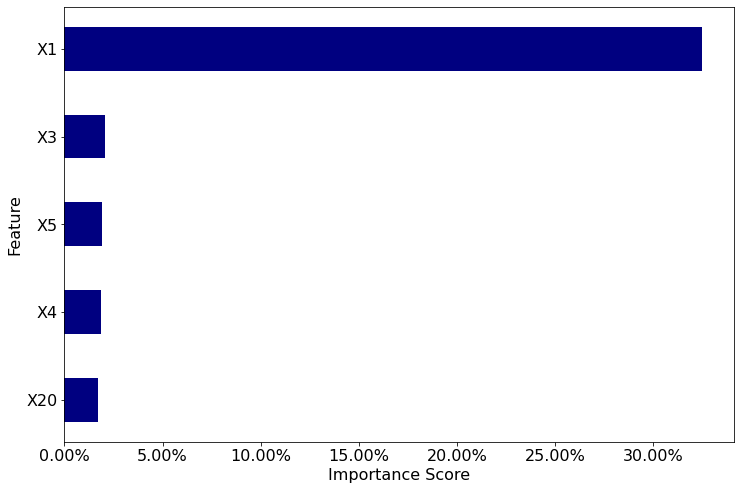

In [10]:
from sklearn.ensemble import RandomForestClassifier

name = "Random Forest"

# Fitting Random Forest
random_forest = RandomForestClassifier(n_estimators=int(n_cols/4), random_state=42)
random_forest.fit(X_train, Y_train)

# Predictions on the test set
Y_pred_binary = random_forest.predict(X_test)
Y_pred = random_forest.predict_proba(X_test)[:, 1]
Y_pred_3 = Y_pred

# Calculate accuracy
accuracy_rf = accuracy_score(Y_test, Y_pred_binary)
print("Random Forest Accuracy:", accuracy_rf)

# Calculate AUC score
auc_score_rf = roc_auc_score(Y_test, Y_pred)
print("Random Forest AUC Score:", auc_score_rf)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', fontsize='large')
plt.grid(True)
plt.savefig(f'roc_curve_{name.lower().replace(" ", "_")}.png', bbox_inches='tight', dpi=500)
plt.show()

# Calculate F1 score
f1 = f1_score(Y_pred_binary, Y_test)
print("F1 Score:", f1)

# Get feature importances
feature_importances = random_forest.feature_importances_
selected_features = X.columns[feature_importances != 0]
print("Selected Features:", selected_features)

# Create a DataFrame to store feature names and importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:int(n_cols/4)]
feature_importance_df

import matplotlib.ticker as ticker
# Set custom font size
plt.rcParams.update({'font.size': 16})

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar chart
ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='navy', height=0.5)

# Set axis labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')


# Invert y-axis for better readability
ax.invert_yaxis()

# Save the plot as a PNG file
#plt.savefig('feature_importance_simulated.png', bbox_inches='tight', dpi=500)

# Show plot
plt.show()

XGBoost Accuracy: 0.9435
XGBoost AUC score: 0.9282982596069288


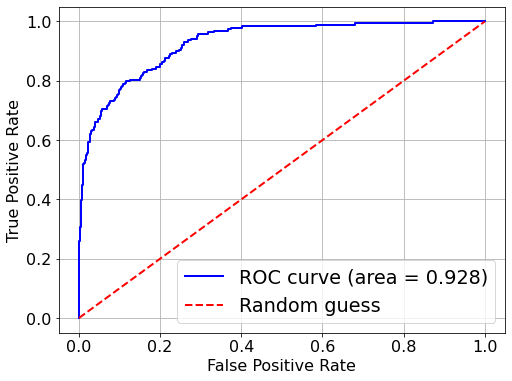

F1 Score: 0.6366559485530547
Selected Features: Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X11_correlated_1', 'X11_correlated_2', 'X11_correlated_3',
       'X11_correlated_4', 'X12_correlated_1', 'X12_correlated_2',
       'X12_correlated_3', 'X12_correlated_4', 'X18_correlated_1',
       'X18_correlated_2', 'X18_correlated_3', 'X18_correlated_4',
       'X19_correlated_1', 'X19_correlated_2', 'X19_correlated_3',
       'X19_correlated_4', 'X6_correlated_1', 'X6_correlated_2',
       'X6_correlated_3', 'X6_correlated_4', 'X3_correlated_1',
       'X3_correlated_2', 'X3_correlated_3', 'X3_correlated_4',
       'X15_correlated_1', 'X15_correlated_2', 'X15_correlated_3',
       'X15_correlated_4', 'X8_correlated_1', 'X8_correlated_2',
       'X8_correlated_3', 'X8_correlated_4', 'X13_correlated_1',
       'X13_correlated_2', 'X13_correlated_3', 'X13_correlated_4',
       'X14_cor

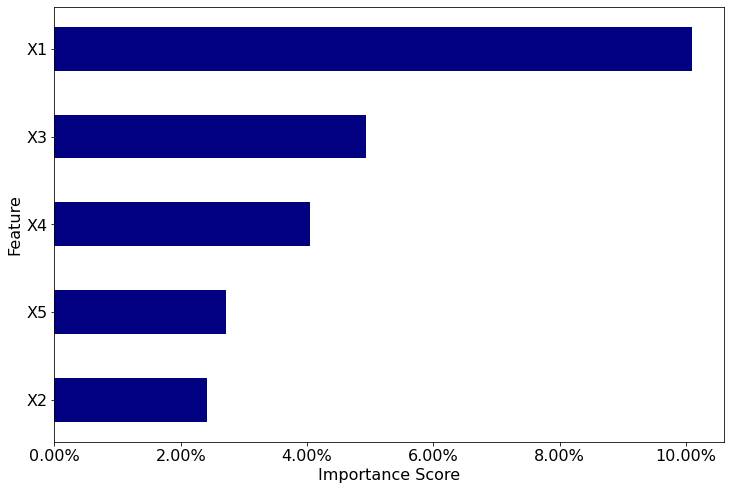

In [11]:
import xgboost as xgb

name = "XGBoost"

# Train XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X_train, Y_train)

# Predictions on the test set
Y_pred_binary = model.predict(X_test)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_4 = Y_pred

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred_binary)
print("XGBoost Accuracy:", accuracy)

# Calculate AUC score
auc_score = roc_auc_score(Y_test, Y_pred)
print("XGBoost AUC score:", auc_score)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', fontsize='large')
plt.grid(True)
plt.savefig(f'roc_curve_{name.lower().replace(" ", "_")}.png', bbox_inches='tight', dpi=500)
plt.show()

# Calculate F1 score
f1 = f1_score(Y_pred_binary, Y_test)
print("F1 Score:", f1)

# Get selected features
feature_importance = model.feature_importances_
selected_features = X.columns[feature_importance != 0]
print("Selected Features:", selected_features)

# Create a DataFrame to store feature names and importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:int(n_cols/4)]
feature_importance_df

import matplotlib.ticker as ticker
# Set custom font size
plt.rcParams.update({'font.size': 16})

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar chart
ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='navy', height=0.5)

# Set axis labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')


# Invert y-axis for better readability
ax.invert_yaxis()

# Save the plot as a PNG file
plt.savefig('feature_importance_simulated.png', bbox_inches='tight', dpi=500)

# Show plot
plt.show()

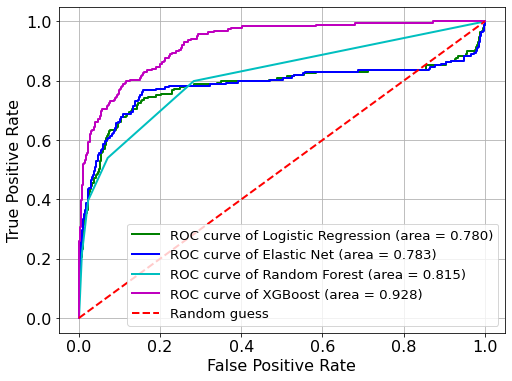

In [12]:
# Plot ROC curve
candidate_models = ["Logistic Regression", "Elastic Net", "Random Forest", "XGBoost"]
color_list = ['g', 'b', 'c', 'm']
plt.figure(figsize=(8, 6))
for i in range(1, 5):
    Y_pred_tmp = globals()[f"Y_pred_{i}"]
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_tmp)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color_list[i-1], lw=2, label=f'ROC curve of {candidate_models[i-1]} (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.savefig(f'roc_curves.svg', format='svg', bbox_inches='tight', dpi=1000)
plt.show()

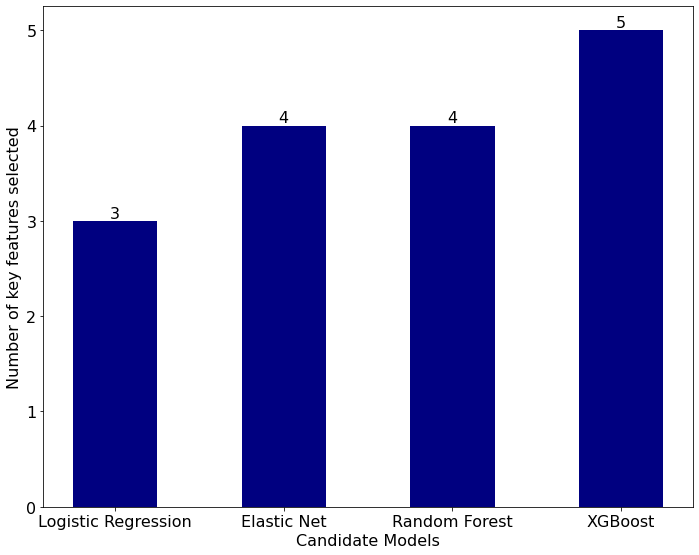

In [13]:
import matplotlib.pyplot as plt

# Data
models = ["Logistic Regression", "Elastic Net", "Random Forest", "XGBoost"]
scores = [3, 4, 4, 5]

# Create bar plot
plt.figure(figsize=(10, 8))
bars = plt.bar(models, scores, color='navy', width=0.5)

# Annotate bars with values
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(score), ha='center', va='bottom')
plt.xlabel('Candidate Models')
plt.ylabel('Number of key features selected')
#plt.title('Number of key features selected among top 5 features of candidate models')
#plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Save the plot as a PNG file
plt.savefig('n_features_selected.svg', format='svg', bbox_inches='tight', dpi=500)
# Show plot
plt.show()

# Real data

In [35]:
from generate_real_data import generate_real_data
df = generate_real_data(cutoff=75)
df.head()

,collection_id,subjectkey,src_subject_id,interview_date,interview_age,sex,eventname,rsfmri_c_ngd_visitid,rsfmri_c_ngd_tr,rsfmri_c_ngd_numtrs,...,rsfmri_c_ngd_vs_ngd_n,rsfmri_c_ngd_vs_ngd_rspltp,rsfmri_c_ngd_vs_ngd_smh,rsfmri_c_ngd_vs_ngd_smm,rsfmri_c_ngd_vs_ngd_sa,rsfmri_c_ngd_vs_ngd_vta,rsfmri_c_ngd_vs_ngd_vs,collection_title,cbcl_scr_07_ocd_t,outcome
0,2573,NDAR_INVXYLTMBZ9,NDAR_INVXYLTMBZ9,12/20/2017,127,F,baseline_year_1_arm_1,S090_INVXYLTMBZ9_20171227,0.8,1532,...,-0.137765,0.022117,-0.006578,0.082179,-0.278462,-0.195811,0.478831,Adolescent Brain Cognitive Development Study (...,50.0,0
1,2573,NDAR_INV03CV8RDT,NDAR_INV03CV8RDT,08/16/2017,128,M,baseline_year_1_arm_1,S065_INV03CV8RDT_20170816,0.8,1149,...,-0.050205,0.055756,-0.071855,-0.082996,0.033737,-0.083230,0.373939,Adolescent Brain Cognitive Development Study (...,60.0,0
2,2573,NDAR_INVL4BZZED1,NDAR_INVL4BZZED1,06/09/2018,115,F,baseline_year_1_arm_1,G031_INVL4BZZED1_20180609,0.8,1564,...,0.033027,0.108406,0.085708,-0.038399,-0.067576,-0.019127,0.252861,Adolescent Brain Cognitive Development Study (...,55.0,0
5,2573,NDAR_INV908NEAJ2,NDAR_INV908NEAJ2,04/21/2018,110,F,baseline_year_1_arm_1,G031_INV908NEAJ2_20180421,0.8,1564,...,-0.027429,-0.012589,0.017271,0.011547,-0.094633,-0.002046,0.286909,Adolescent Brain Cognitive Development Study (...,50.0,0
6,2573,NDAR_INV9M8UXK0A,NDAR_INV9M8UXK0A,04/11/2017,109,M,baseline_year_1_arm_1,S053_INV9M8UXK0A_20170412,0.8,1532,...,-0.087244,0.226859,-0.164828,-0.120868,-0.287843,-0.225691,0.446261,Adolescent Brain Cognitive Development Study (...,50.0,0


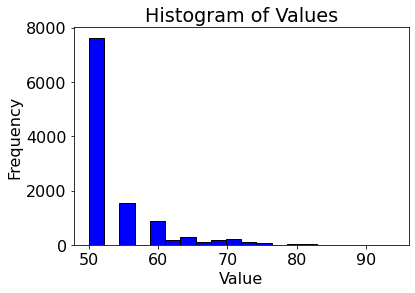

In [36]:
# Plot histogram of the 'value' column
import matplotlib.pyplot as plt

plt.hist(df['cbcl_scr_07_ocd_t'], bins=20, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Show plot
plt.show()

In [37]:
df['outcome'].value_counts()

0    11166
1      143
Name: outcome, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Splitting data into features (X) and target (Y)
predictive_cols = [col for col in df.columns if col.startswith('rsfmri') and 'visitid' not in col]
for col in predictive_cols:
        if df[col].dtype != 'object':  # Exclude string/object columns
            mean_col = df[col].mean()
            df[col] = df[col].fillna(mean_col)
X = df[predictive_cols]
Y = df['outcome']

# Splitting data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

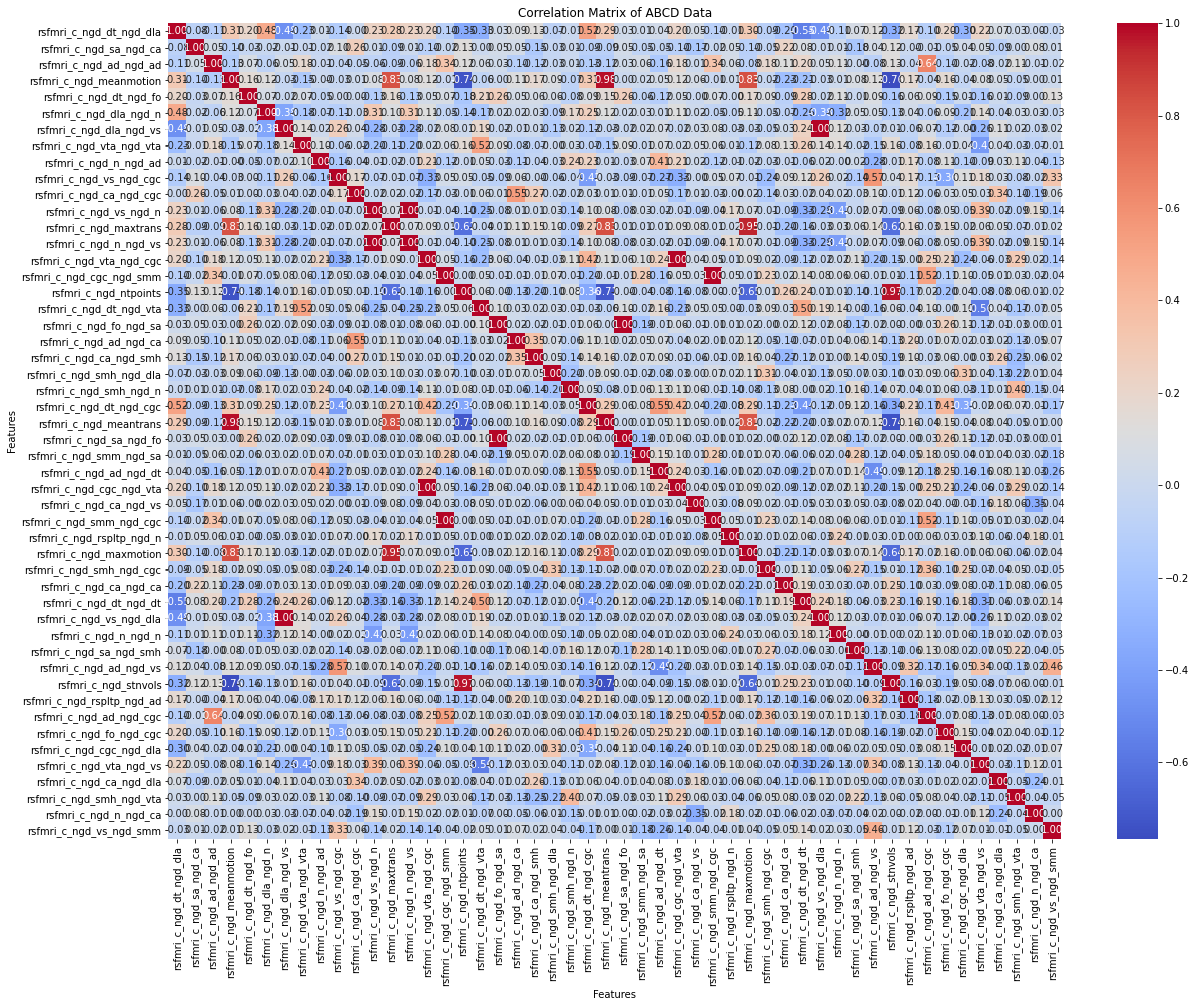

In [9]:
# Compute correlation matrix
import seaborn as sns
from matplotlib import pyplot as plt
correlation_matrix = X.sample(n=50, axis='columns').corr()

# Plot correlation matrix using seaborn heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of ABCD Data")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Fitting Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)

# Predict probabilities on the test set
Y_pred = log_reg.predict_proba(X_test)[:, 1]
Y_pred_binary = (Y_pred > 0.1).astype(int)  # Converting predicted probabilities to binary

accuracy = accuracy_score(Y_test, Y_pred_binary)
print("Accuracy:", accuracy)

# Calculate AUC score
auc_score_log_reg = roc_auc_score(Y_test, Y_pred)
print("Logistic Regression AUC Score:", auc_score_log_reg)

# Calculate F1 score
f1 = f1_score(Y_pred_binary, Y_test)
print("F1 Score:", f1)

Accuracy: 0.9023810408231492
Logistic Regression AUC Score: 0.516097143720145
F1 Score: 0.06742370475514549


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Fitting Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, Y_train)

# Predictions on the test set
Y_pred_binary = random_forest.predict(X_test)
Y_pred = random_forest.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy_rf = accuracy_score(Y_test, Y_pred_binary)
print("Random Forest Accuracy:", accuracy_rf)

# Calculate AUC score
auc_score_rf = roc_auc_score(Y_test, Y_pred)
print("Random Forest AUC Score:", auc_score_rf)

# Calculate F1 score
f1 = f1_score(Y_pred_binary, Y_test)
print("F1 Score:", f1)

# Get feature importances
feature_importances = random_forest.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the top features
top_features = X.columns[sorted_indices]
print(f"Top {len(top_features)} Features Selected by Random Forest:", top_features)

Random Forest Accuracy: 0.9547193640652278
Random Forest AUC Score: 0.9635619554375431
F1 Score: 0.6004588659455916
Top 181 Features Selected by Random Forest: Index(['rsfmri_c_ngd_meanrot', 'rsfmri_c_ngd_maxrot', 'rsfmri_c_ngd_stnvols',
       'rsfmri_c_ngd_maxmotion', 'rsfmri_c_ngd_maxtrans',
       'rsfmri_c_ngd_meantrans', 'rsfmri_c_ngd_meanmotion',
       'rsfmri_c_ngd_stcontignvols', 'rsfmri_c_ngd_rspltp_ngd_rspltp',
       'rsfmri_c_ngd_ntpoints',
       ...
       'rsfmri_c_ngd_sa_ngd_ca', 'rsfmri_c_ngd_vta_ngd_dt',
       'rsfmri_c_ngd_dla_ngd_dt', 'rsfmri_c_ngd_smm_ngd_rspltp',
       'rsfmri_c_ngd_fo_ngd_ad', 'rsfmri_c_ngd_vs_ngd_vta',
       'rsfmri_c_ngd_smm_ngd_dt', 'rsfmri_c_ngd_numtrs', 'rsfmri_c_ngd_nvols',
       'rsfmri_c_ngd_tr'],
      dtype='object', length=181)


In [31]:
from sklearn.linear_model import ElasticNetCV

# Fit Elastic Net model with cross-validation to select features
enet = ElasticNetCV(cv=10, random_state=42, l1_ratio=0.001)
enet.fit(X_train, Y_train)

# Predict on the test set
Y_pred = enet.predict(X_test)
Y_pred_binary = (Y_pred > 0.1).astype(int)  # Converting predicted probabilities to binary

accuracy = accuracy_score(Y_test, Y_pred_binary)
print("Accuracy:", accuracy)

# Calculate AUC score
auc_score = roc_auc_score(Y_test, Y_pred)
print("AUC Score:", auc_score)

# Calculate F1 score
f1 = f1_score(Y_pred_binary, Y_test)
print("F1 Score:", f1)

# Get selected features
selected_features = X.columns[enet.coef_ != 0]
print(f"Selected {len(selected_features)} Features:")
print(selected_features)

Accuracy: 0.9370751457969615
AUC Score: 0.5149643831413364
F1 Score: 0.0
Selected 4 Features:
Index(['rsfmri_c_ngd_nvols', 'rsfmri_c_ngd_stnvols',
       'rsfmri_c_ngd_stcontignvols', 'rsfmri_c_ngd_ntpoints'],
      dtype='object')


XGBoost Accuracy: 0.9849690539345711
XGBoost AUC score: 0.5916015418734819


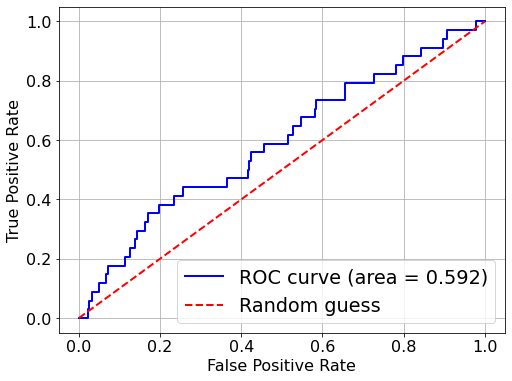

F1 Score: 0.0
Selected Features: Index(['rsfmri_c_ngd_tr', 'rsfmri_c_ngd_numtrs', 'rsfmri_c_ngd_stnvols',
       'rsfmri_c_ngd_stcontignvols', 'rsfmri_c_ngd_ntpoints',
       'rsfmri_c_ngd_meanmotion', 'rsfmri_c_ngd_maxmotion',
       'rsfmri_c_ngd_meantrans', 'rsfmri_c_ngd_maxtrans',
       'rsfmri_c_ngd_meanrot',
       ...
       'rsfmri_c_ngd_smm_ngd_smm', 'rsfmri_c_ngd_smm_ngd_sa',
       'rsfmri_c_ngd_smm_ngd_vta', 'rsfmri_c_ngd_smm_ngd_vs',
       'rsfmri_c_ngd_sa_ngd_sa', 'rsfmri_c_ngd_sa_ngd_vta',
       'rsfmri_c_ngd_sa_ngd_vs', 'rsfmri_c_ngd_vta_ngd_vta',
       'rsfmri_c_ngd_vta_ngd_vs', 'rsfmri_c_ngd_vs_ngd_vs'],
      dtype='object', length=102)


In [8]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score

# Train XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X_train, Y_train)

# Predictions on the test set
Y_pred_binary = model.predict(X_test)
Y_pred = model.predict_proba(X_test)[:, 1]
Y_pred_4 = Y_pred

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred_binary)
print("XGBoost Accuracy:", accuracy)

# Calculate AUC score
auc_score = roc_auc_score(Y_test, Y_pred)
print("XGBoost AUC score:", auc_score)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', fontsize='large')
plt.grid(True)
plt.show()

# Calculate F1 score
f1 = f1_score(Y_pred_binary, Y_test)
print("F1 Score:", f1)

# Get selected features
selected_features = X.columns[model.feature_importances_ != 0]
print("Selected Features:", selected_features)

In [39]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score

# Train XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X, Y)

selected_features = X.columns[model.feature_importances_ != 0]
print("Selected Features:", selected_features)

Selected Features: Index(['rsfmri_c_ngd_tr', 'rsfmri_c_ngd_numtrs', 'rsfmri_c_ngd_stnvols',
       'rsfmri_c_ngd_stcontignvols', 'rsfmri_c_ngd_ntpoints',
       'rsfmri_c_ngd_meanmotion', 'rsfmri_c_ngd_maxmotion',
       'rsfmri_c_ngd_meantrans', 'rsfmri_c_ngd_maxtrans',
       'rsfmri_c_ngd_meanrot',
       ...
       'rsfmri_c_ngd_smm_ngd_smm', 'rsfmri_c_ngd_smm_ngd_sa',
       'rsfmri_c_ngd_smm_ngd_vta', 'rsfmri_c_ngd_smm_ngd_vs',
       'rsfmri_c_ngd_sa_ngd_sa', 'rsfmri_c_ngd_sa_ngd_vta',
       'rsfmri_c_ngd_sa_ngd_vs', 'rsfmri_c_ngd_vta_ngd_vta',
       'rsfmri_c_ngd_vta_ngd_vs', 'rsfmri_c_ngd_vs_ngd_vs'],
      dtype='object', length=102)


In [51]:
import pandas as pd
codebook = pd.read_csv("codebook.csv")
# Get feature importance scores
feature_importance = model.feature_importances_

# Create a DataFrame to store feature names and importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort features by importance
feature_importance_df = pd.merge(feature_importance_df, codebook, how='left', left_on='Feature', right_on='Variable_name')
feature_importance_df = feature_importance_df[~feature_importance_df['Explain'].str.contains(""" "none" """)]
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:5]
map_biomarker = dict(zip(feature_importance_df['Feature'].tolist(), feature_importance_df['Explain'].tolist()))

In [52]:
for i in list(map_biomarker.values()):
    print(i)

Average correlation between auditory network and visual network
Average correlation between salience network and visual network
Average correlation between visual network and visual network
Average correlation between cingulo-parietal network and fronto-parietal network
Average correlation between retrosplenial temporal network and ventral attention network


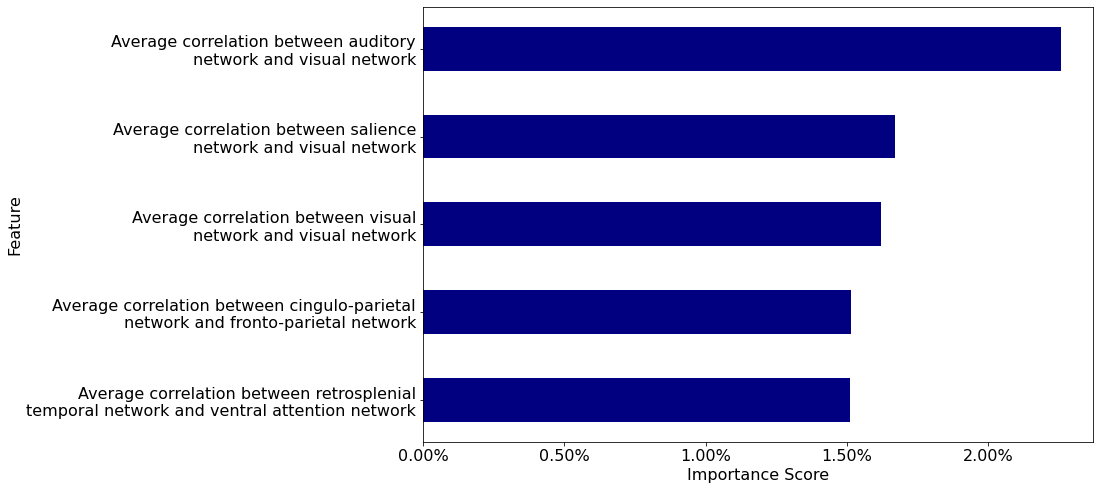

In [56]:
import matplotlib.ticker as ticker
# Set custom font size
plt.rcParams.update({'font.size': 16})

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar chart
ax.barh(feature_importance_df['Feature'].apply(lambda x: map_biomarker[x].replace(" ", "\n", 4).replace("\n", " ", 3)), feature_importance_df['Importance'], color='navy', height=0.5)

# Set axis labels
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')


# Invert y-axis for better readability
ax.invert_yaxis()

# Save the plot as a PNG file
plt.savefig('feature_importance.svg', format='svg', bbox_inches='tight', dpi=500)
plt.savefig('feature_importance.png', bbox_inches='tight', dpi=500)

# Show plot
plt.show()

In [54]:
feature_importance_df

,Feature,Importance,Variable_name,Explain,Dataset
24,rsfmri_c_ngd_ad_ngd_vs,0.022572,rsfmri_c_ngd_ad_ngd_vs,Average correlation between auditory network a...,betnet02
154,rsfmri_c_ngd_sa_ngd_vs,0.016707,rsfmri_c_ngd_sa_ngd_vs,Average correlation between salience network a...,betnet02
180,rsfmri_c_ngd_vs_ngd_vs,0.016214,rsfmri_c_ngd_vs_ngd_vs,Average correlation between visual network and...,betnet02
43,rsfmri_c_ngd_ca_ngd_fo,0.015135,rsfmri_c_ngd_ca_ngd_fo,Average correlation between cingulo-parietal n...,betnet02
114,rsfmri_c_ngd_rspltp_ngd_vta,0.015101,rsfmri_c_ngd_rspltp_ngd_vta,Average correlation between retrosplenial temp...,betnet02
